In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.phenotype_process.configuration_utils import annotate_on_phenotyping_data
from lib.sbs_process.configuration_utils import annotate_segment_on_sequencing_data

In [90]:
def get_segmentation_images(base_path):
    """
    Get cell, nuclei, and aligned images from a base path.
    
    Args:
        base_path (str): Original path from the dataframe
        
    Returns:
        tuple: (nuclei_path, cells_path, aligned_path)
    """
    print("base path", base_path)
    # Remove extension "_segmentation_stats.tsv"
    prefix = base_path.replace("_segmentation_stats.tsv", "")
    
    # Create paths for nuclei and cells
    nuclei_path = f"{prefix}_nuclei.tiff"
    cells_path = f"{prefix}_cells.tiff"

    # Get aligned image path by replacing /paramsearch/tsvs/ with /
    aligned_path = base_path.replace("/paramsearch/", "/")
    # Remove parameters and stats suffix
    aligned_path = aligned_path.split("__paramsearch")[0] + "__aligned.tiff"
    
    return nuclei_path, cells_path, aligned_path

def evaluate_segmentation_sbs(df,
                              default_cell_diameter=None,   
                              default_nuclei_diameter=None,
                              default_cellprob_threshold=None,
                              default_flow_threshold=None,
                              ):
    """
    Calculate averages for each parameter combination and visualize results.
    Now includes loading and displaying actual segmentation results.
    
    Args:
        df (pd.DataFrame): Input DataFrame with parameters and segmentation data
        default_cell_diameter (float, optional): Default cell diameter
        default_nuclei_diameter (float, optional): Default nuclei diameter
        default_cellprob_threshold (float, optional): Default cell probability threshold
        default_flow_threshold (float, optional): Default flow threshold
        min_measurements (int, optional): Minimum number of measurements required
    """
    # [Previous statistics calculation code remains the same]
    param_cols = ['nuclei_diameter', 'cell_diameter', 'flow_threshold', 'cellprob_threshold']
    
    df['cell_retention'] = df['final_cells'] / df['after_edge_removal_cells'] 
    df['nuclei_retention'] = df['final_nuclei'] / df['after_edge_removal_nuclei']
    
    metrics = [
        'initial_nuclei',
        'initial_cells',
        'final_cells',
        'final_nuclei',
        'cell_retention',
        'nuclei_retention'
    ]
    
    grouped_stats = df.groupby(param_cols)[metrics].agg({
        'initial_nuclei': ['mean'],
        'initial_cells': ['mean'],
        'final_cells': ['mean'],
        'final_nuclei': ['mean'],
        'cell_retention': ['mean'],
        'nuclei_retention': ['mean']
    }).round(2)
    
    grouped_stats.columns = [f"{col[0]}_{col[1]}" for col in grouped_stats.columns]
    grouped_stats['measurement_count'] = df.groupby(param_cols).size()
    
    grouped_stats['combined_score'] = (
        grouped_stats['cell_retention_mean'] * 
        grouped_stats['nuclei_retention_mean'] * 
        grouped_stats['final_cells_mean'] 
    )
    
    grouped_stats = grouped_stats.sort_values('combined_score', ascending=False)
    best_params = grouped_stats.index[0]
    best_stats = grouped_stats.iloc[0]

    # Print statistics
    print("\n=== Segmentation Parameter Optimization Summary ===")
    print(f"\nOptimal Parameters:")
    print(f"• Nuclei Diameter: {best_params[0]:.2f}")
    print(f"• Cell Diameter: {best_params[1]:.2f}")
    print(f"• Flow Threshold: {best_params[2]:.2f}")
    print(f"• Cell Probability Threshold: {best_params[3]:.2f}")
    
    print("\nPerformance Metrics:")
    print(f"• Cell Retention: {best_stats['cell_retention_mean']*100:.1f}%")
    print(f"• Nuclei Retention: {best_stats['nuclei_retention_mean']*100:.1f}%")
    print(f"• Final Cells (avg): {best_stats['final_cells_mean']:.0f}")
    print(f"• Final Nuclei (avg): {best_stats['final_nuclei_mean']:.0f}")
    print(f"• Number of measurements: {best_stats['measurement_count']}")
    print(f"• Combined Score: {best_stats['combined_score']:.1f}")

    # Print default parameters if provided
    if default_cell_diameter is not None:
        default_params = (default_nuclei_diameter, default_cell_diameter, default_flow_threshold, default_cellprob_threshold)
        default_stats = grouped_stats.loc[default_params]
        
        print("\nDefault Parameters:")
        print(f"• Nuclei Diameter: {default_nuclei_diameter:.2f}")
        print(f"• Cell Diameter: {default_cell_diameter:.2f}")
        print(f"• Flow Threshold: {default_flow_threshold:.2f}")
        print(f"• Cell Probability Threshold: {default_cellprob_threshold:.2f}")
        
        print("\nPerformance Metrics:")
        print(f"• Cell Retention: {default_stats['cell_retention_mean']*100:.1f}%")
        print(f"• Nuclei Retention: {default_stats['nuclei_retention_mean']*100:.1f}%")
        print(f"• Final Cells (avg): {default_stats['final_cells_mean']:.0f}")
        print(f"• Final Nuclei (avg): {default_stats['final_nuclei_mean']:.0f}")
        print(f"• Number of measurements: {default_stats['measurement_count']}")
        print(f"• Combined Score: {default_stats['combined_score']:.1f}")


    # Get a row with optimal parameters
    optimal_example = df[
        (df['nuclei_diameter'] == best_params[0]) &
        (df['cell_diameter'] == best_params[1]) &
        (df['flow_threshold'] == best_params[2]) &
        (df['cellprob_threshold'] == best_params[3])
    ].iloc[0]
    
    optimal_nuclei_path, optimal_cells_path, optimal_aligned_path = get_segmentation_images(optimal_example['path'])
    
    if default_cell_diameter is not None:
        # Get a row with default parameters
        default_example = df[
            (df['nuclei_diameter'] == default_nuclei_diameter) &
            (df['cell_diameter'] == default_cell_diameter) &
            (df['flow_threshold'] == default_flow_threshold) &
            (df['cellprob_threshold'] == default_cellprob_threshold)
        ].iloc[0]
        
        default_nuclei_path, default_cells_path, default_aligned_path = get_segmentation_images(default_example['path'])
        
        # Create visualization
        optimal_nuclei = imread(optimal_nuclei_path)
        optimal_cells = imread(optimal_cells_path)            
        default_nuclei = imread(default_nuclei_path)
        default_cells = imread(default_cells_path)
        aligned = imread(optimal_aligned_path)

        annotated_optimal = annotate_segment_on_sequencing_data(aligned, optimal_nuclei, optimal_cells)
        annotated_default = annotate_segment_on_sequencing_data(aligned, default_nuclei, default_cells)

        optimal_microshow = microplot.Microimage(annotated_optimal[0], channel_names="Optimal")
        default_microshow = microplot.Microimage(annotated_default[0], channel_names="Default")
        panel = Micropanel(rows=1, cols=2, figscaling=10)
        panel.add_element([0, 0], optimal_microshow)
        panel.add_element([0, 1], default_microshow)
        panel.add_channel_label() 
        plt.show()
    
    return grouped_stats

def evaluate_segmentation_ph(df,
                             default_cell_diameter=None,   
                             default_nuclei_diameter=None,
                             default_cellprob_threshold=None,
                             default_flow_threshold=None,
                             ):
    """
    Calculate averages for each parameter combination and visualize results.
    Now includes loading and displaying actual segmentation results.
    
    Args:
        df (pd.DataFrame): Input DataFrame with parameters and segmentation data
        default_cell_diameter (float, optional): Default cell diameter
        default_nuclei_diameter (float, optional): Default nuclei diameter
        default_cellprob_threshold (float, optional): Default cell probability threshold
        default_flow_threshold (float, optional): Default flow threshold
        min_measurements (int, optional): Minimum number of measurements required
    """
    # [Previous statistics calculation code remains the same]
    param_cols = ['nuclei_diameter', 'cell_diameter', 'flow_threshold', 'cellprob_threshold']
    
    df['cell_retention'] = df['final_cells'] / df['after_edge_removal_cells'] 
    df['nuclei_retention'] = df['final_nuclei'] / df['after_edge_removal_nuclei']
    
    metrics = [
        'initial_nuclei',
        'initial_cells',
        'final_cells',
        'final_nuclei',
        'cell_retention',
        'nuclei_retention'
    ]
    
    grouped_stats = df.groupby(param_cols)[metrics].agg({
        'initial_nuclei': ['mean'],
        'initial_cells': ['mean'],
        'final_cells': ['mean'],
        'final_nuclei': ['mean'],
        'cell_retention': ['mean'],
        'nuclei_retention': ['mean']
    }).round(2)
    
    grouped_stats.columns = [f"{col[0]}_{col[1]}" for col in grouped_stats.columns]
    grouped_stats['measurement_count'] = df.groupby(param_cols).size()
    
    grouped_stats['combined_score'] = (
        grouped_stats['cell_retention_mean'] * 
        grouped_stats['nuclei_retention_mean'] * 
        grouped_stats['final_cells_mean'] 
    )
    
    grouped_stats = grouped_stats.sort_values('combined_score', ascending=False)
    best_params = grouped_stats.index[0]
    best_stats = grouped_stats.iloc[0]

    # Print statistics
    print("\n=== Segmentation Parameter Optimization Summary ===")
    print(f"\nOptimal Parameters:")
    print(f"• Nuclei Diameter: {best_params[0]:.2f}")
    print(f"• Cell Diameter: {best_params[1]:.2f}")
    print(f"• Flow Threshold: {best_params[2]:.2f}")
    print(f"• Cell Probability Threshold: {best_params[3]:.2f}")
    
    print("\nPerformance Metrics:")
    print(f"• Cell Retention: {best_stats['cell_retention_mean']*100:.1f}%")
    print(f"• Nuclei Retention: {best_stats['nuclei_retention_mean']*100:.1f}%")
    print(f"• Final Cells (avg): {best_stats['final_cells_mean']:.0f}")
    print(f"• Final Nuclei (avg): {best_stats['final_nuclei_mean']:.0f}")
    print(f"• Number of measurements: {best_stats['measurement_count']}")
    print(f"• Combined Score: {best_stats['combined_score']:.1f}")

    # Print default parameters if provided
    if default_cell_diameter is not None:
        default_params = (default_nuclei_diameter, default_cell_diameter, default_flow_threshold, default_cellprob_threshold)
        default_stats = grouped_stats.loc[default_params]
        
        print("\nDefault Parameters:")
        print(f"• Nuclei Diameter: {default_nuclei_diameter:.2f}")
        print(f"• Cell Diameter: {default_cell_diameter:.2f}")
        print(f"• Flow Threshold: {default_flow_threshold:.2f}")
        print(f"• Cell Probability Threshold: {default_cellprob_threshold:.2f}")
        
        print("\nPerformance Metrics:")
        print(f"• Cell Retention: {default_stats['cell_retention_mean']*100:.1f}%")
        print(f"• Nuclei Retention: {default_stats['nuclei_retention_mean']*100:.1f}%")
        print(f"• Final Cells (avg): {default_stats['final_cells_mean']:.0f}")
        print(f"• Final Nuclei (avg): {default_stats['final_nuclei_mean']:.0f}")
        print(f"• Number of measurements: {default_stats['measurement_count']}")
        print(f"• Combined Score: {default_stats['combined_score']:.1f}")

    # Get a row with optimal parameters
    optimal_example = df[
        (df['nuclei_diameter'] == best_params[0]) &
        (df['cell_diameter'] == best_params[1]) &
        (df['flow_threshold'] == best_params[2]) &
        (df['cellprob_threshold'] == best_params[3])
    ].iloc[0]
    
    optimal_nuclei_path, optimal_cells_path, optimal_aligned_path = get_segmentation_images(optimal_example['path'])
    
    if default_cell_diameter is not None:
        # Get a row with default parameters
        default_example = df[
            (df['nuclei_diameter'] == default_nuclei_diameter) &
            (df['cell_diameter'] == default_cell_diameter) &
            (df['flow_threshold'] == default_flow_threshold) &
            (df['cellprob_threshold'] == default_cellprob_threshold)
        ].iloc[0]
        
        default_nuclei_path, default_cells_path, default_aligned_path = get_segmentation_images(default_example['path'])
        
        # Create visualization
        optimal_nuclei = imread(optimal_nuclei_path)
        optimal_cells = imread(optimal_cells_path)            
        default_nuclei = imread(default_nuclei_path)
        default_cells = imread(default_cells_path)
        aligned = imread(optimal_aligned_path)

        print(aligned.shape)

        annotated_optimal = annotate_on_phenotyping_data(aligned, optimal_nuclei, optimal_cells)
        annotated_default = annotate_on_phenotyping_data(aligned, default_nuclei, default_cells)

        optimal_microshow = microplot.Microimage(annotated_optimal[0], channel_names="Optimal")
        default_microshow = microplot.Microimage(annotated_default[0], channel_names="Default")
        panel = Micropanel(rows=1, cols=2, figscaling=10)
        panel.add_element([0, 0], optimal_microshow)
        panel.add_element([0, 1], default_microshow)
        panel.add_channel_label() 
        plt.show()
    
    return grouped_stats

In [91]:
summary_sbs = pd.read_csv('analysis_root/sbs_process/paramsearch/summary/segmentation_summary.tsv', sep='\t')

default_cell_diameter=19.77080019204319
default_nuclei_diameter=8.740387444736633
default_cellprob_threshold=0
default_flow_threshold=0.4


=== Segmentation Parameter Optimization Summary ===

Optimal Parameters:
• Nuclei Diameter: 6.74
• Cell Diameter: 17.77
• Flow Threshold: 0.60
• Cell Probability Threshold: 2.00

Performance Metrics:
• Cell Retention: 94.0%
• Nuclei Retention: 96.0%
• Final Cells (avg): 3058
• Final Nuclei (avg): 3058
• Number of measurements: 2.0
• Combined Score: 2760.0

Default Parameters:
• Nuclei Diameter: 8.74
• Cell Diameter: 19.77
• Flow Threshold: 0.40
• Cell Probability Threshold: 0.00

Performance Metrics:
• Cell Retention: 92.0%
• Nuclei Retention: 94.0%
• Final Cells (avg): 2927
• Final Nuclei (avg): 2927
• Number of measurements: 2.0
• Combined Score: 2531.3
base path analysis_root/sbs_process/paramsearch/images/WA1_T1__paramsearch_nd6.740387444736633_cd17.77080019204319_ft0.6_cp2_segmentation_stats.tsv
base path analysis_root/sbs_process/paramsearch/images/WA1_T1__paramsearch_nd8.740387444736633_cd19.77080019204319_ft0.4_cp0_segmentation_stats.tsv


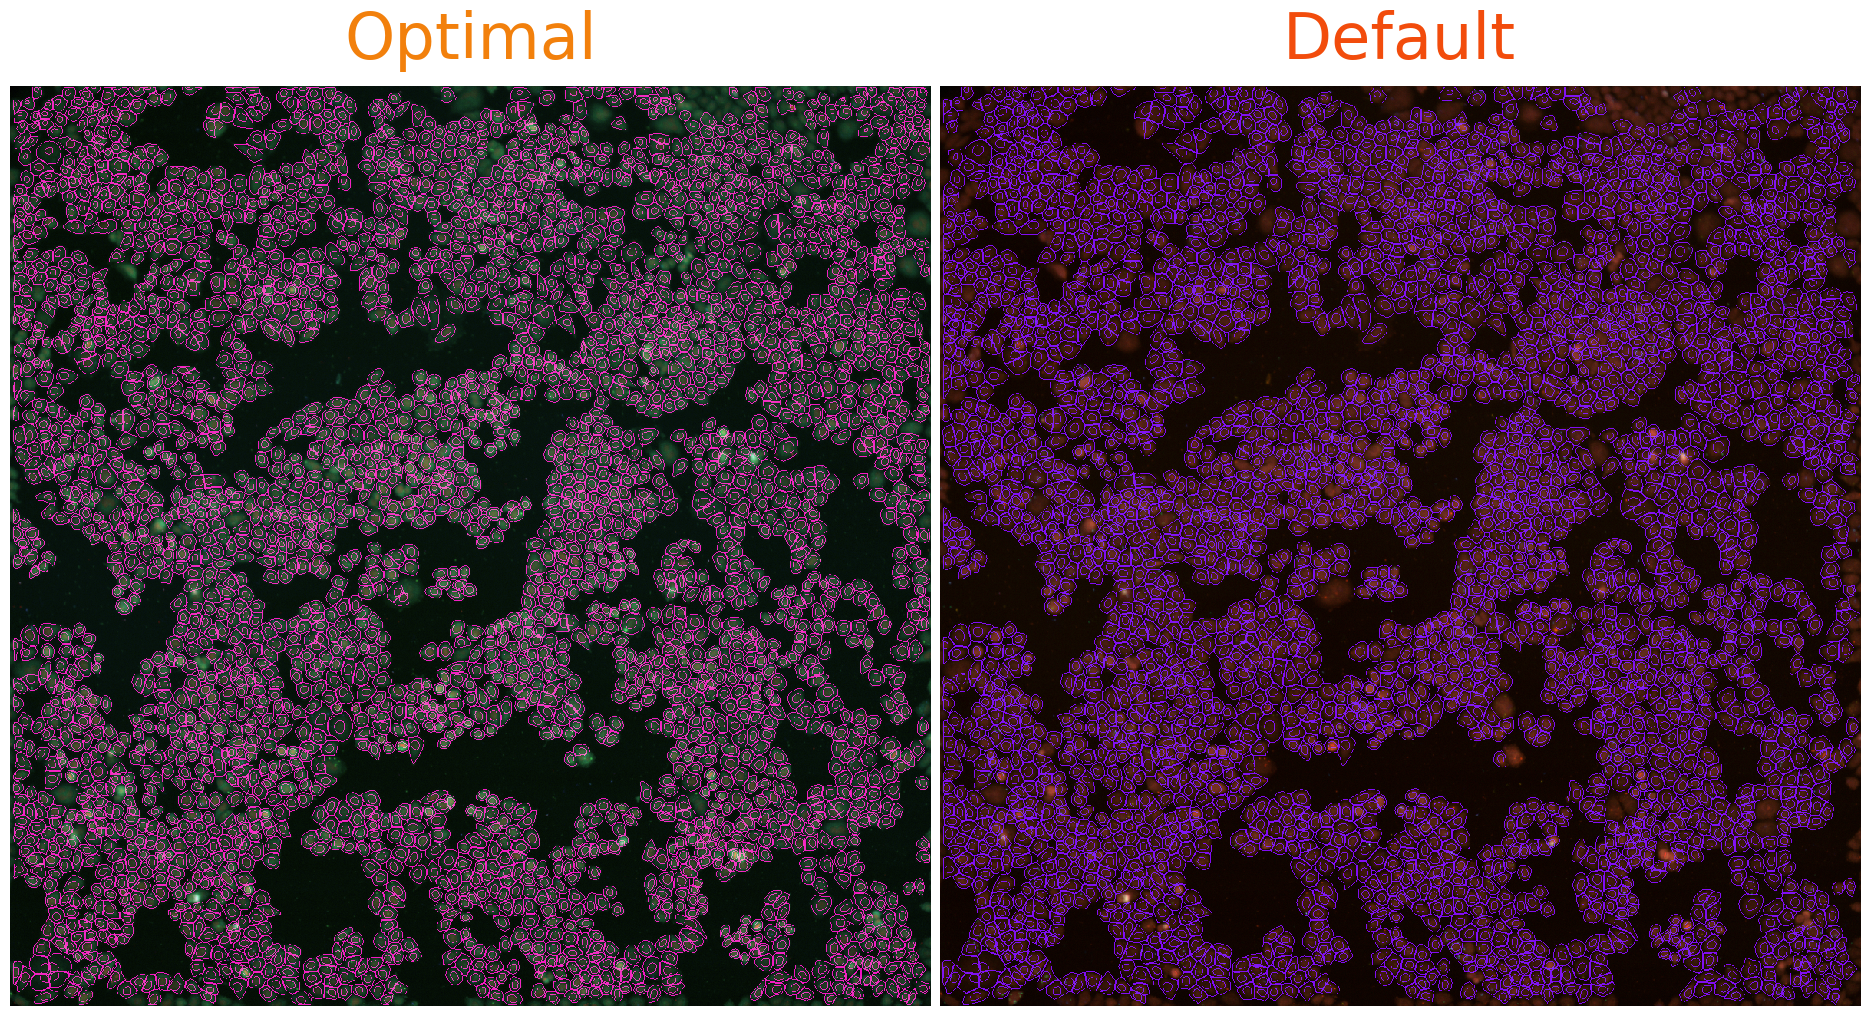

initial_nuclei_mean  \
nuclei_diameter cell_diameter flow_threshold cellprob_threshold                        
6.740387        17.7708       0.6             2.0                             3220.0   
                              0.4             2.0                             3220.0   
                              0.6             0.0                             3220.0   
                                              4.0                             3220.0   
                              0.4             0.0                             3220.0   
...                                                                              ...   
8.740387        19.7708       0.2            -4.0                             3154.0   
6.740387        21.7708       0.2            -4.0                             3220.0   
10.740387       19.7708       0.2            -4.0                             3109.0   
8.740387        21.7708       0.2            -4.0                             3154.0   
10.740387       21.7708       0.2            -4.0                             3109.0   

                                                                 initial_cells_mean  \
nuclei_diameter cell_diameter flow_threshold cellprob_threshold                       
6.740387        17.7708       0.6             2.0                            3296.0   
                              0.4             2.0                            3285.0   
                              0.6             0.0                            3307.5   
                                              4.0                            3271.5   
                              0.4             0.0                            3287.0   
...                                                                             ...   
8.740387        19.7708       0.2            -4.0                            1778.5   
6.740387        21.7708       0.2            -4.0                            1732.5   
10.740387       19.7708       0.2            -4.0                            1778.5   
8.740387        21.7708       0.2            -4.0                            1732.5   
10.740387       21.7708       0.2            -4.0                            1732.5   

                                                                 final_cells_mean  \
nuclei_diameter cell_diameter flow_threshold cellprob_threshold                     
6.740387        17.7708       0.6             2.0                          3058.5   
                              0.4             2.0                          3051.5   
                              0.6             0.0                          3029.5   
                                              4.0                          3053.5   
                              0.4             0.0                          3017.0   
...                                                                           ...   
8.740387        19.7708       0.2            -4.0                          1604.0   
6.740387        21.7708       0.2            -4.0                          1595.5   
10.740387       19.7708       0.2            -4.0                          1580.5   
8.740387        21.7708       0.2            -4.0                          1552.5   
10.740387       21.7708       0.2            -4.0                          1534.0   

                                                                 final_nuclei_mean  \
nuclei_diameter cell_diameter flow_threshold cellprob_threshold                      
6.740387        17.7708       0.6             2.0                           3058.5   
                              0.4             2.0                           3051.5   
                              0.6             0.0                           3029.5   
                                              4.0                           3053.5   
                              0.4             0.0                           3017.0   
...                                                                            .

In [92]:
evaluate_segmentation_sbs(summary_sbs, 
                          default_nuclei_diameter=default_nuclei_diameter, 
                          default_cell_diameter=default_cell_diameter, 
                          default_flow_threshold=default_flow_threshold, 
                          default_cellprob_threshold=default_cellprob_threshold)

In [93]:
summary_ph = pd.read_csv('analysis_root/phenotype_process/paramsearch/summary/segmentation_summary.tsv', sep='\t')

default_cell_diameter=52.75700564655907
default_nuclei_diameter=41.30545956583848
default_cellprob_threshold=0
default_flow_threshold=0.4

In [94]:
evaluate_segmentation_ph(summary_ph, 
                         default_nuclei_diameter=default_nuclei_diameter, 
                         default_cell_diameter=default_cell_diameter, 
                         default_flow_threshold=default_flow_threshold, 
                         default_cellprob_threshold=default_cellprob_threshold)


=== Segmentation Parameter Optimization Summary ===

Optimal Parameters:
• Nuclei Diameter: 36.31
• Cell Diameter: 47.76
• Flow Threshold: 0.60
• Cell Probability Threshold: 0.00

Performance Metrics:
• Cell Retention: 94.0%
• Nuclei Retention: 94.0%
• Final Cells (avg): 912
• Final Nuclei (avg): 912
• Number of measurements: 2.0
• Combined Score: 805.8

Default Parameters:
• Nuclei Diameter: 41.31
• Cell Diameter: 52.76
• Flow Threshold: 0.40
• Cell Probability Threshold: 0.00

Performance Metrics:
• Cell Retention: 94.0%
• Nuclei Retention: 94.0%
• Final Cells (avg): 901
• Final Nuclei (avg): 901
• Number of measurements: 2.0
• Combined Score: 796.1
base path analysis_root/phenotype_process/paramsearch/tsvs/WA1_T1__paramsearch_nd36.30545956583848_cd47.75700564655907_ft0.6_cp0_segmentation_stats.tsv
base path analysis_root/phenotype_process/paramsearch/tsvs/WA1_T1__paramsearch_nd41.30545956583848_cd52.75700564655907_ft0.4_cp0_segmentation_stats.tsv


FileNotFoundError: [Errno 2] No such file or directory: '/lab/barcheese01/mdiberna/brieflow/example_analysis/analysis_root/phenotype_process/paramsearch/tsvs/WA1_T1__paramsearch_nd36.30545956583848_cd47.75700564655907_ft0.6_cp0_nuclei.tiff'